In [134]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import date
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
from seaborn_qqplot import pplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas

data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_99322/4142588568.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Update mobility variables

In [168]:
#income and age added in census folder notebook before continuing here
mob_vars = pd.read_csv(data_path + 'mobility_heat/mob_vars_final_clean_90_v1.csv')
#relative_heat = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/relative_heat_scores.csv')

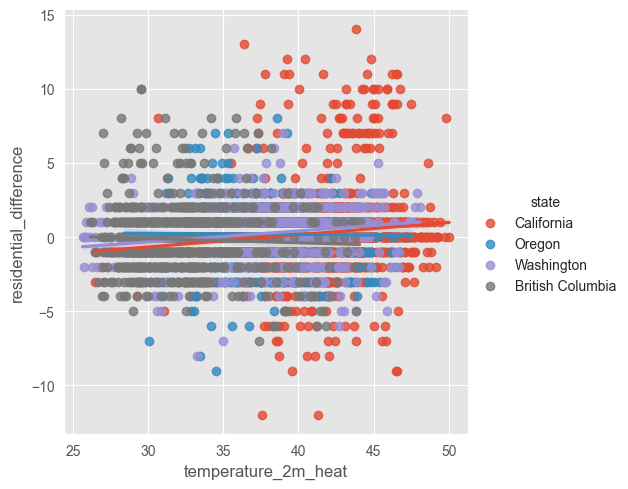

In [175]:
sns.lmplot(mob_vars, x='temperature_2m_heat', y='residential_difference', hue='state')

In [136]:
mob_vars['date'] = pd.to_datetime(mob_vars['date'])

In [137]:
mob_vars['month'] = [x.month for x in mob_vars['date']]

### Add winter temperatures

In [138]:
winter = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/winter_v2.csv')

In [139]:
mob_vars = mob_vars.merge(winter[['location', 'temperature_2m_winter']])

### Build >=5 duration variable

In [140]:
mob_vars['heatwave_dur'] = ['<5 days' if x<5 else '>=5 days' for x in mob_vars['Heat Wave Duration']]
mob_vars['hw_dur_>=_5'] = [0 if x=='<5 days' else 1 for x in mob_vars['heatwave_dur']]

### Get stage_frac variables

In [141]:
mob_vars['stage_frac'] = mob_vars['stage'] / mob_vars['Heat Wave Duration'] * 100


In [142]:
mob_vars['stage_frac'].describe()


count    6596.000000
mean       63.764445
std        28.356145
min         9.090909
25%        40.000000
50%        62.500000
75%       100.000000
max       100.000000
Name: stage_frac, dtype: float64

In [143]:
mob_vars.to_csv(data_path + 'mobility_heat/final_premultivariate_clean_90_v1.csv')

# Add/prepare final variables multivariate


In [144]:
mob_vars = pd.read_csv(data_path + 'mobility_heat/final_premultivariate_clean_90_v1.csv')

## Merge coastal 

In [145]:
coast_variable = pd.read_csv(data_path + 'mobility_heat/multivariate_modelling_v25.csv')
coast_variable.drop_duplicates('location', inplace=True)

In [146]:
mob_vars = mob_vars.merge(coast_variable[['location', 'coast_binary']], on='location')

In [147]:
df = mob_vars.copy()

### Remove Outliers

In [148]:
df['workplaces_difference'] = [np.nan if abs(x) >= df['workplaces_difference'].mean() + (3 * df['workplaces_difference'].std()) else x for x in df['workplaces_difference'] ]

df['residential_difference'] = [np.nan if abs(x) >= df['residential_difference'].mean() + (3 * df['residential_difference'].std()) else x for x in df['residential_difference'] ]

df['grocery_pharmacy_difference'] = [np.nan if abs(x) >= df['grocery_pharmacy_difference'].mean() + (3 * df['grocery_pharmacy_difference'].std()) else x for x in df['grocery_pharmacy_difference'] ]

df['parks_difference'] = [np.nan if abs(x)>= df['parks_difference'].mean() + (3 * df['parks_difference'].std()) else x for x in df['parks_difference'] ]

df['retail_difference'] = [np.nan if abs(x) >= df['retail_difference'].mean() + (3 * df['retail_difference'].std()) else x for x in df['retail_difference'] ]

df['transit_difference'] = [np.nan if abs(x) >= df['transit_difference'].mean() + (3 * df['transit_difference'].std()) else x for x in df['transit_difference'] ]

#v13
df.dropna(how='all', subset=['workplaces_difference', 'residential_difference', 'transit_difference', 'grocery_pharmacy_difference', 'parks_difference', 'retail_difference'], inplace=True)

### Center heat wave temperature variable

In [149]:
df['heat_temp_centered'] = df['temperature_2m_heat'] - df['temperature_2m_heat'].mean()


### Get Large city Variables

In [150]:
df['large_city'] = [x if x in ['Los Angeles County', 'San Diego County', 'Santa Clara County', 'San Francisco County', 'Sacramento County', 'King County', 'Multnomah County', 'Greater Vancouver'] else 'nonmajor' for x  in df['county']]

### Get coast binary as digit

In [151]:
df['coast_binary'] = df['coast_binary'] * 1

### Get June heatwave variable

In [152]:
df = df[['temperature_2m_heat', 'month', 'date_heat', 'control_day', 'Heat Wave Duration', 'large_city', 'date', 'location', 'heat_ID_x', 'workplaces_difference', 'residential_difference', 'grocery_pharmacy_difference', 'retail_difference', 'parks_difference', 'transit_difference', 'state', 'year', 'weekend', 'stage_frac', 'heatwave_dur', 'temp_diff', 'heat_temp_centered', 'coast_binary', 'temperature_2m_winter', 'income_dec', 'over65_dec', 'nonwhite_dec','large_city', 'popdens_dec']]

In [153]:
df['index'] = range(0, len(df))

In [154]:
df['date'] = pd.to_datetime(df['date'])

In [155]:
df['month'] = [x.month for x in df['date']]

In [156]:
df['month'].unique()

array([6, 7, 8, 9])

In [157]:
df['june_hw'] = df.groupby(['heat_ID_x'])['month'].transform(lambda x: 6 in x.unique())
df['june_hw'] = df['june_hw'] * 1



In [158]:
df['month'].value_counts()

7    2465
8    2312
6     961
9     823
Name: month, dtype: int64

In [159]:
df.rename(columns={'heat_ID_x': 'heat_ID'}, inplace=True)

In [160]:
df.reset_index(inplace=True, drop=True)

In [161]:
df.to_csv(data_path + 'mobility_heat/final_multivariate_clean_90_v1.csv')

In [162]:
df['workplaces_difference'].describe()

count    6246.000000
mean       -0.474063
std         3.956758
min       -24.000000
25%        -2.000000
50%         0.000000
75%         1.000000
max        23.000000
Name: workplaces_difference, dtype: float64

In [133]:
df[['residential_difference', 'workplaces_difference', 'transit_difference', 'grocery_pharmacy_difference', 'retail_difference', 'parks_difference']].describe()

,residential_difference,workplaces_difference,transit_difference,grocery_pharmacy_difference,retail_difference,parks_difference
count,5225.000000,6246.000000,3665.000000,4865.000000,5633.000000,3055.000000
mean,0.022584,-0.474063,-0.777899,0.897225,0.439553,-2.769231
std,1.636194,3.956758,7.901640,5.992879,6.513067,25.316906
min,-6.000000,-24.000000,-31.000000,-23.000000,-25.000000,-94.000000
25%,-1.000000,-2.000000,-5.000000,-2.000000,-3.000000,-16.000000
50%,0.000000,0.000000,-1.000000,1.000000,0.000000,-5.000000
75%,1.000000,1.000000,3.000000,4.000000,3.000000,7.000000
max,6.000000,23.000000,30.000000,23.000000,25.000000,96.000000


In [167]:
df.columns

Index(['temperature_2m_heat', 'month', 'date_heat', 'control_day',
       'Heat Wave Duration', 'large_city', 'date', 'location', 'heat_ID',
       'workplaces_difference', 'residential_difference',
       'grocery_pharmacy_difference', 'retail_difference', 'parks_difference',
       'transit_difference', 'state', 'year', 'weekend', 'stage_frac',
       'heatwave_dur', 'temp_diff', 'heat_temp_centered', 'coast_binary',
       'temperature_2m_winter', 'income_dec', 'over65_dec', 'nonwhite_dec',
       'large_city', 'popdens_dec', 'index', 'june_hw'],
      dtype='object')

In [ ]:
1.97755   
0.11843   
10.92858   
-1.80401   
1.17207   
47.63493   
-1.52765   
-3.32851   
4.09959   
20.18643   
-1.69504   
-0.11542   
9.84762   
10.81173   
25.80007   
-6.86684   
-8.95254   
4.00448   
43.41347   
35.06221   
440.61025   